# Comparing CC3 and CC2

Notebook to check how CC2 and CC3 models compare, because currently the results coming out look wrong.

In [1]:
cc2_showerflow_path = "/data/dust/user/dayhallh/point-cloud-diffusion-data/showerFlow/p22_th90_ph90_en10-100/ShowerFlow_original_nb10_inputs36893488147419103231_best.pth"
cc3_showerflow_path = "/data/dust/user/dayhallh/point-cloud-diffusion-data/showerFlow/sim-E1261AT600AP180-180/ShowerFlow_alt1_nb2_inputs8070450532247928831_fnorms_best.pth"
cc2_diffusion_path = "/data/dust/user/dayhallh/point-cloud-diffusion-logs/from_anatoli/CC2/ckpt_0.000000_1000000.pt"

# must use config.diffusion_pointwise_hidden_l1 = 32
cc3_diffusion_path = "/data/dust/user/dayhallh/point-cloud-diffusion-logs/from_anatoli/CC3/ckpt_0.000000_6135000.pt"

# vanilla
#cc3_diffusion_path = "/data/dust/user/dayhallh/point-cloud-diffusion-logs/sim-E1261AT600AP180-180/Anatoliis_cc_2.pt"

# shared drive

#TODO work out what cog scaling this showerflow2 needs
cc2_showerflow_path = "/data/dust/group/ilc/sft-ml/model_weights/CaloClouds/CC2/220714_cog_e_layer_ShowerFlow_best.pth"
cc3_showerflow_path = "/data/dust/group/ilc/sft-ml/model_weights/CaloClouds/CC3/ShowerFlow_alt1_nb2_inputs8070450532247928831_fnorms_dhist_best.pth"
cc2_diffusion_path = "/data/dust/group/ilc/sft-ml/model_weights/CaloClouds/CC2/ckpt_0.000000_1000000.pt"
cc3_diffusion_path = "/data/dust/group/ilc/sft-ml/model_weights/CaloClouds/CC3/ckpt_0.000000_6135000.pt"

from pointcloud.config_varients import caloclouds_3_simple_shower, caloclouds_2, default
from pointcloud.evaluation.bin_standard_metrics import get_caloclouds_models
from pointcloud.data.conditioning import normalise_cond_feats
from pointcloud.utils.metadata import Metadata

cc_2_configs = caloclouds_2.Configs()
cc_2_configs.dataset_path_in_storage = False
cc_2_configs.dataset_path = "/data/dust/user/dayhallh/data/ILCsoftEvents/p22_th90_ph90_en10-100_joined/p22_th90_ph90_en10-100_seed{}_all_steps.hdf5"
cc_2_configs.n_dataset_files = 10
cc_2_configs.shower_flow_roll_xyz = True
cc_2_configs.distillation = True
cc_2_meta = Metadata(cc_2_configs)
cc_2_meta.vis_eng_rescale = 1.
cc_2_configs.metadata = cc_2_meta

cc_models = get_caloclouds_models(cc2_diffusion_path, cc2_showerflow_path, caloclouds_names="CC2", configs=cc_2_configs)
cc_3_configs = caloclouds_3_simple_shower.Configs()
cc_3_configs.diffusion_pointwise_hidden_l1 = 32
cc_3_configs.distillation = True
cc_models.update(get_caloclouds_models(cc3_diffusion_path, cc3_showerflow_path, caloclouds_names="CC3", configs=cc_3_configs))
print(cc_models.keys())


/data/dust/group/ilc/sft-ml/model_weights/CaloClouds/CC2/ckpt_0.000000_1000000.pt
original_nb4 has best loss -170.3614442786392
alt1_nb4 has best loss -162.38868557676977
alt1_nb4_wo[0, 1] has best loss -127.89362487792968
alt2_nb4 has best loss -128.3624267578125
alt2_nb4_wo[0, 1] has best loss -121.22644805908203
alt2_nb4_wo[0, 1, 2, 3, 4] has best loss -121.57145843505859
Found 62 saved models
/data/dust/group/ilc/sft-ml/model_weights/CaloClouds/CC2/220714_cog_e_layer_ShowerFlow_best.pth
/data/dust/group/ilc/sft-ml/model_weights/CaloClouds/CC3/ckpt_0.000000_6135000.pt
original_nb4_fnorms_wo[0, 1, 4] has best loss -145.9351401815609
alt1_nb4_fnorms_wo[0, 1, 4] has best loss -147.62754416952328
Found 10 saved models
/data/dust/group/ilc/sft-ml/model_weights/CaloClouds/CC3/ShowerFlow_alt1_nb2_inputs8070450532247928831_fnorms_dhist_best.pth
dict_keys(['CC2', 'CC3'])


In [2]:
default.Configs().dataset_path

'/beegfs/desy/user/akorol/data/calo-clouds/hdf5/high_granular_grid/train/10-90GeV_x36_grid_regular_524k_float32.hdf5'

Now get some sample conditioning values with which to compare the models.
The same ones will be used for both models, however, the expected scaling may be different.


In [3]:
from pointcloud.data.conditioning import read_raw_regaxes_withcond
all_cond_configs = caloclouds_2.Configs()
all_cond_configs.dataset_path_in_storage = False
all_cond_configs.dataset_path = "/data/dust/user/dayhallh/data/ILCsoftEvents/p22_th90_ph90_en10-100_joined/p22_th90_ph90_en10-100_seed{}_all_steps.hdf5"
all_cond_configs.n_dataset_files = 10
all_cond_configs.cond_features_names = ["energy", "points", "p_norm_local"]
all_cond_configs.cond_features = 5
if True:
    cond, events = read_raw_regaxes_withcond(all_cond_configs, total_size=10_000, for_model=['diffusion'])
print(cond[:10])


Selecting evenly spaced events
tensor([[4.3710e+01, 2.8140e+03, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        [1.1853e+01, 9.7800e+02, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        [6.5068e+01, 3.6360e+03, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        [6.4681e+01, 3.5170e+03, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        [2.0984e+01, 1.4570e+03, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        [9.7265e+01, 5.1030e+03, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        [4.4982e+01, 2.7990e+03, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        [7.9504e+01, 4.3230e+03, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        [8.7681e+01, 4.8520e+03, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        [2.0764e+01, 1.5480e+03, 0.0000e+00, 0.0000e+00, 1.0000e+00]],
       dtype=torch.float64)


Make cond for both CC2 and CC3


In [4]:

all_cond_meta = Metadata(all_cond_configs)
original_cc2_max_points = 6_000
normalised_cond2 = cond.clone()
normalised_cond3 = cond.clone()
#normalised_cond[:, 3] = 0
#normalised_cond[:, 4] = 1
normalised_cond2[:, 0] /= all_cond_meta.incident_rescale
normalised_cond3[:, 0] /= 127
normalised_cond2[:, 1] = (normalised_cond2[:, 1]/original_cc2_max_points)*2 - 1
showerflow_cond = {"CC2": normalised_cond2[:, [0]], "CC3": normalised_cond3[:, [0, 2, 3, 4]]}
# for the diffusion models, the energy goes between -1 and 1
normalised_cond2[:, 0] = normalised_cond2[:, 0]*2 - 1
# for CC3, the energy is log scaled and standardised
# these values are for hit energies, need the ones for the training dataset
Emean, Estd = -1.5300317, 1.2500798
#normalised_cond3[:, 0] = ((normalised_cond3[:, 0]).log()-Emean)/Estd
#normalised_cond3[:, 0] = normalised_cond3[:, 0]/127
diffusion_cond = {"CC2": normalised_cond2[:, [0, 1]], "CC3":normalised_cond3[:, [0, 2, 3, 4]]}

In [5]:
conditioned_samples = {}
point_per_event = 100
for name in cc_models:
    diffusion, flow_dist, configs = cc_models[name]
    d_cond = diffusion_cond[name].float()
    s_diffusion = diffusion.sample(d_cond, point_per_event, all_cond_configs)
    s_cond = showerflow_cond[name].float()
    s_showerflow = flow_dist.condition(s_cond).sample([len(s_cond)])
    conditioned_samples[name] = (s_diffusion, s_showerflow)

    

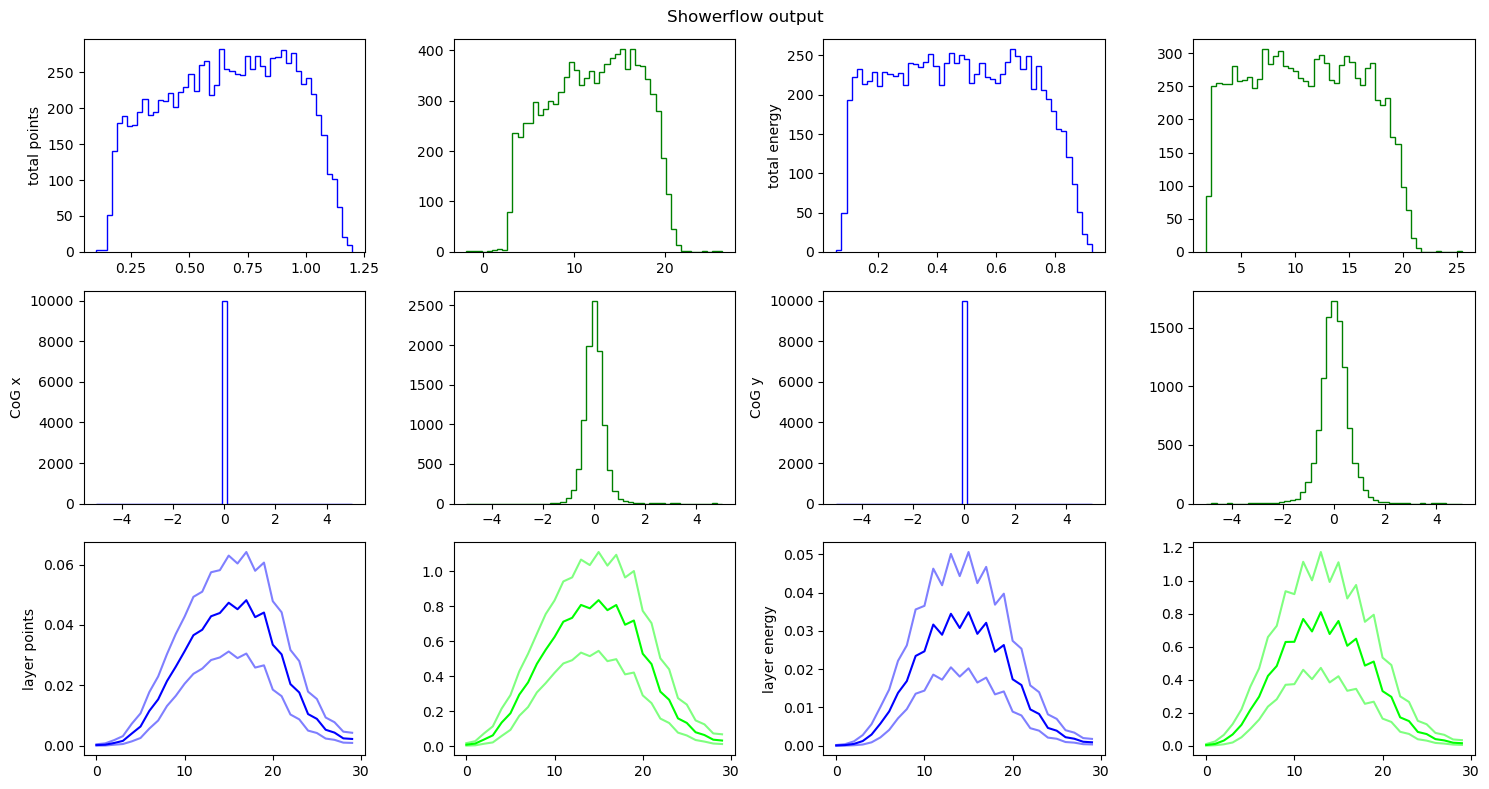

In [6]:
from matplotlib import pyplot as plt
import numpy as np
fig, ax_arr = plt.subplots(3, 4, figsize=(15, 8))
ax_arr = ax_arr.flatten()
fig.suptitle("Showerflow output")
hist2_settings = dict(label='CC2', color='blue', histtype="step", bins=np.linspace(-5, 5, 50))
hist3_settings = dict(label='CC3', color='green', histtype="step", bins=np.linspace(-5, 5, 50))


i=4
ax_arr[i].set_ylabel("CoG x")
cc2_v = conditioned_samples["CC2"][1][:, 4]
cc3_v = conditioned_samples["CC3"][1][:, 0]

ax_arr[i].hist(cc2_v, **hist2_settings)
ax_arr[i+1].hist(cc3_v, **hist3_settings)

i=6
ax_arr[i].set_ylabel("CoG y")
cc2_v = conditioned_samples["CC2"][1][:, 2]
cc3_v = conditioned_samples["CC3"][1][:, 1]

ax_arr[i].hist(cc2_v, **hist2_settings)
ax_arr[i+1].hist(cc3_v, **hist3_settings)

i=0
# total points
hist2_settings['bins'] = 50
hist3_settings['bins'] = 50
ax_arr[i].set_ylabel("total points")
cc2_v = conditioned_samples["CC2"][1][:, 0]
cc3_v = conditioned_samples["CC3"][1][:, -60:-30].sum(dim=1)

ax_arr[i].hist(cc2_v, **hist2_settings)
ax_arr[i+1].hist(cc3_v, **hist3_settings)

i=8
ax_arr[i].set_ylabel("layer points")
layer_pnts2 = np.zeros((3, 30))
raw = conditioned_samples["CC2"][1][:, -60:-30]
raw_totals = raw.sum(dim=1)
renormed = raw*(cc2_v[:, None]/raw_totals[:, None])
layer_pnts3 = np.zeros((3, 30))
quantiles = [0.25, 0.5, 0.75]
for l in range(30):
    layer_pnts2[:, l] = np.quantile(renormed[:, l], quantiles)
    layer_pnts3[:, l] = np.quantile(conditioned_samples["CC3"][1][:, -60+l], quantiles)
colour = ((0, 0, 1, 0.5), (0, 0, 1, 1), (0, 0, 1, 0.5))
for j in range(3):
    ax_arr[i].plot(range(30), layer_pnts2[j], color=colour[j])
colour = ((0, 1, 0, 0.5), (0, 1, 0, 1), (0, 1, 0, 0.5))
for j in range(3):
    ax_arr[i+1].plot(range(30), layer_pnts3[j], color=colour[j])



i=2
# total energy
ax_arr[i].set_ylabel("total energy")
cc2_v = conditioned_samples["CC2"][1][:, 1]
cc3_v = conditioned_samples["CC3"][1][:, -30:].sum(dim=1)

ax_arr[i].hist(cc2_v, **hist2_settings)
ax_arr[i+1].hist(cc3_v, **hist3_settings)

i=10
ax_arr[i].set_ylabel("layer energy")
layer_e2 = np.zeros((3, 30))
raw = conditioned_samples["CC2"][1][:, -30:]
raw_totals = raw.sum(dim=1)
renormed = raw*(cc2_v[:, None]/raw_totals[:, None])
layer_e3 = np.zeros((3, 30))
quantiles = [0.25, 0.5, 0.75]
for l in range(30):
    layer_e2[:, l] = np.quantile(renormed[:, l], quantiles)
    layer_e3[:, l] = np.quantile(conditioned_samples["CC3"][1][:, -30+l], quantiles)
colour = ((0, 0, 1, 0.5), (0, 0, 1, 1), (0, 0, 1, 0.5))
for j in range(3):
    ax_arr[i].plot(range(30), layer_e2[j], color=colour[j])
colour = ((0, 1, 0, 0.5), (0, 1, 0, 1), (0, 1, 0, 0.5))
for j in range(3):
    ax_arr[i+1].plot(range(30), layer_e3[j], color=colour[j])

plt.tight_layout()

In [7]:
n_pnts = (events[..., -1] > 0).sum(axis=1)
energy = events[..., -1].sum(axis=1)/all_cond_meta.vis_eng_rescale
cog_x = ((events[..., -1]*events[..., 0]/events[..., [-1]].sum(axis=1)).sum(axis=1)-all_cond_meta.mean_cog[0])/all_cond_meta.std_cog[0]
cog_y = ((events[..., -1]*events[..., 1]/events[..., [-1]].sum(axis=1)).sum(axis=1)-all_cond_meta.mean_cog[1])/all_cond_meta.std_cog[1]
raw_cog_x = (events[..., -1]*events[..., 0]/events[..., [-1]].sum(axis=1)).sum(axis=1)
raw_cog_y = (events[..., -1]*events[..., 1]/events[..., [-1]].sum(axis=1)).sum(axis=1)



In [28]:

cc2_stats = np.load(cc2_showerflow_path.replace(".pth", "_stats_cond_p22_th90_ph90_en10-100.npz"))
cc3_stats = np.load(cc3_showerflow_path.replace(".pth", "_stats_cond_p22_th90_ph90_en10-100.npz"))
dataset_stats = np.load("/data/dust/user/dayhallh/data/ILCsoftEvents/p22_th90_ph90_en10-100_joined/stats.npz")
for key in dataset_stats.keys():
    print(key, dataset_stats[key])

cc3_train_ds_meta = Metadata(caloclouds_3_simple_shower.Configs())
try:
    del all_cond_configs.metadata
except AttributeError:
    pass
cc_3_meta = Metadata(all_cond_configs)
# we need actual cog for this dataset
cc_3_meta.n_pts_rescale = cc3_train_ds_meta.n_pts_rescale

cc_3_meta.vis_eng_rescale = cc3_train_ds_meta.vis_eng_rescale/cc_3_meta.vis_eng_rescale
cc_3_meta.incident_rescale = 127

# internally, showers are assumed to be scaled between 0 and 1
# but in cc3, they are actually normalised to std=0.5 mean=0
# so we can alter Zmax_global, Zmin_global, Xmax_global and Xmin_global
# to get the scaling needed
Xmean, Ymean, Zmean = -0.0074305227, -0.21205868, 12.359252
Xstd, Ystd, Zstd = 22.4728036, 23.65837968, 5.305082

cc_3_meta.Xmax_global = Ymean
cc_3_meta.Xmin_global = 2*Ystd - Ymean
cc_3_meta.Zmax_global = Xmean
cc_3_meta.Zmin_global = 2*Xstd - Xmean



cc_3_meta.std_cog = 1./dataset_stats["std_cog"][[2,0,1]]
print(1./dataset_stats["std_cog"][[2,0,1]])
cc_3_meta.mean_cog[[0, 1]] = [0, 0]
#cc_3_meta.std_cog[:2] = 1/cc3_stats["cog_x_std"], 1/cc3_stats["cog_y_std"]
print(1/cc3_stats["cog_x_std"], 1/cc3_stats["cog_y_std"])
cc_3_meta.mean_cog[:2] = -cc3_stats["cog_x_mean"], -cc3_stats["cog_y_mean"]
cc_3_meta.log_incident_mean = cc3_train_ds_meta.log_incident_mean
cc_3_meta.log_incident_std = cc3_train_ds_meta.log_incident_std

cc_3_meta.found_attrs += ["log_incident_mean", "log_incident_std"]
#print(cc3_train_ds_meta.std_cog, cc_3_meta.std_cog)

cc_2_meta.std_cog[:] = 1/cc2_stats["cog_x_std"], 1/cc2_stats["cog_y_std"], 1/cc2_stats["cog_z_std"]
cc_2_meta.mean_cog[:] = -cc2_stats["cog_x_mean"], -cc2_stats["cog_y_mean"], -cc2_stats["cog_z_mean"]

#print(cc_2_meta.std_cog)

path /data/dust/user/dayhallh/data/ILCsoftEvents/p22_th90_ph90_en10-100_joined/p22_th90_ph90_en10-100_seed{}_all_steps.hdf5
mean_point [ 1.22085438e-04  5.46113000e-01 -1.43398707e-02  3.42128658e-04]
std_point [5.01166184e-03 1.03514488e+00 2.80895001e-02 6.88304610e-04]
mean_event [ 3.82163269e-01  1.70949404e+03 -4.48880056e+01  1.07096315e+00]
std_event [5.18406994e-01 8.18390107e+02 2.19667064e+01 8.19594157e-01]
mean_n_points 3130.29362
std_n_points 1231.3112889384615
mean_cog [ 3.8028497e-01  1.8952594e+03 -4.9972588e+01]
std_cog [ 0.5199222  12.771177    0.48483732]
[2.0625474  1.9233648  0.07830132]
0.8272116 0.9908721


tensor(1.0000) tensor(2.4934) 1.014942009137842
torch.Size([10000]) torch.Size([10000]) (10000,)


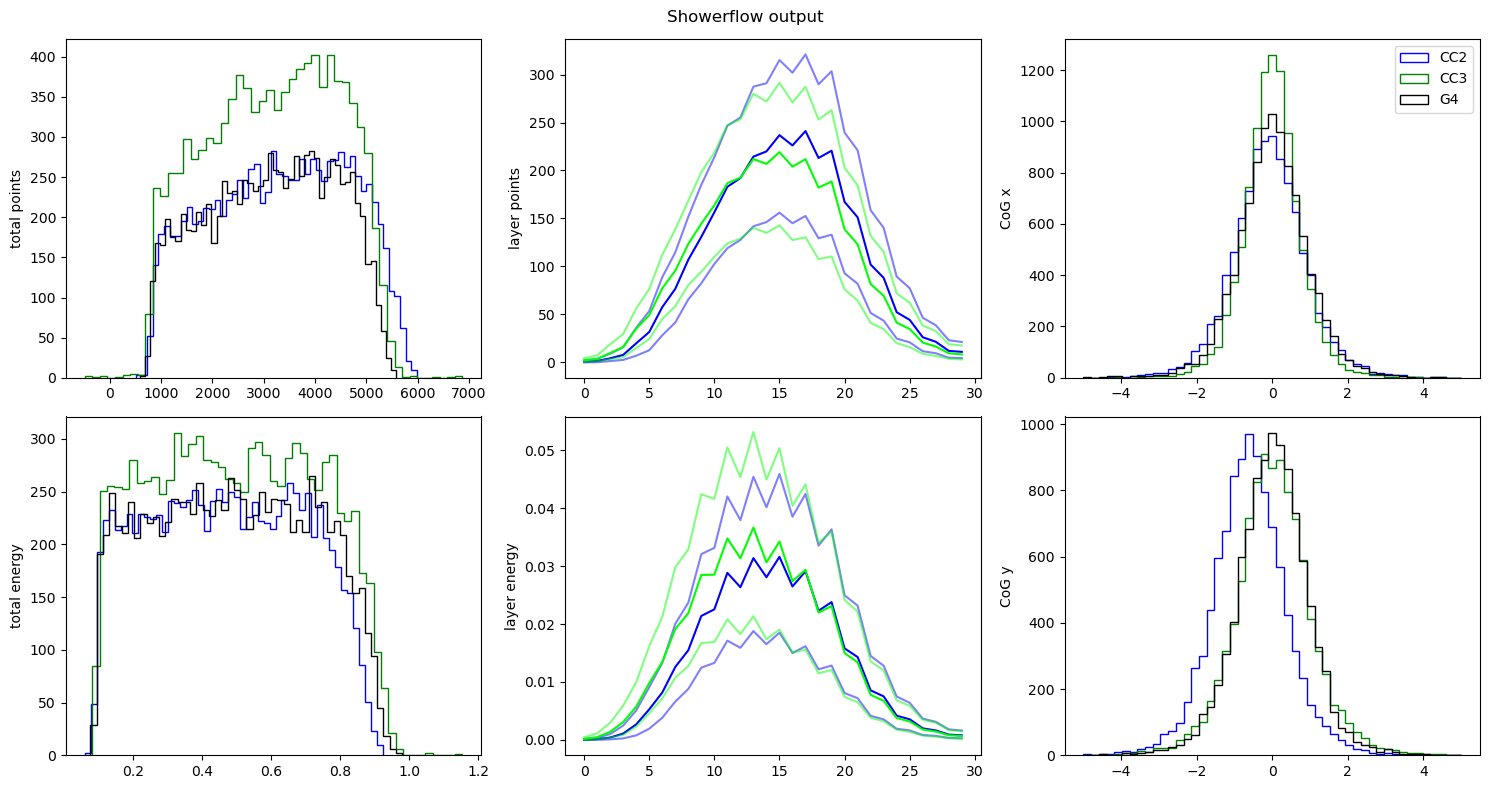

In [27]:
from matplotlib import pyplot as plt
fig, ax_arr = plt.subplots(2, 3, figsize=(15, 8))
ax_arr = ax_arr.flatten()
fig.suptitle("Showerflow output")
hist2_settings = dict(label='CC2', color='blue', histtype="step", bins=np.linspace(-5, 5, 50))
hist3_settings = dict(label='CC3', color='green', histtype="step", bins=np.linspace(-5, 5, 50))
histg4_settings = dict(label='G4', color='k', histtype='step', bins=np.linspace(-5, 5, 50))

i=2
ax_arr[i].set_ylabel("CoG x")
cc2_v = conditioned_samples["CC2"][1][:, 4]*cc_2_meta.std_cog[2]
cc3_v = conditioned_samples["CC3"][1][:, 0]*cc_3_meta.std_cog[0]
print(cc2_v.std(), cc3_v.std(), cog_x.std())
print(cc2_v.shape, cc3_v.shape, cog_x.shape)

ax_arr[i].hist(cc2_v, **hist2_settings)
ax_arr[i].hist(cc3_v, **hist3_settings)
ax_arr[i].hist(cog_x, **histg4_settings)
ax_arr[i].legend()

i=5
ax_arr[i].set_ylabel("CoG y")
cc2_v = conditioned_samples["CC2"][1][:, 2]*cc_2_meta.std_cog[0]
cc3_v = conditioned_samples["CC3"][1][:, 1]*cc_3_meta.std_cog[1]

ax_arr[i].hist(cc2_v, **hist2_settings)
ax_arr[i].hist(cc3_v, **hist3_settings)
ax_arr[i].hist(cog_y, **histg4_settings)

i=0
# total points
hist2_settings['bins'] = 50
hist3_settings['bins'] = 50
histg4_settings['bins'] = 50
ax_arr[i].set_ylabel("total points")
cc2_v = (float(all_cond_meta.n_pts_rescale)*conditioned_samples["CC2"][1][:, 0]).clip(1, 60_000)
cc3_v = float(cc_3_meta.n_pts_rescale/30)*conditioned_samples["CC3"][1][:, -60:-30].sum(dim=1)

ax_arr[i].hist(cc2_v, **hist2_settings)
ax_arr[i].hist(cc3_v, **hist3_settings)
ax_arr[i].hist(n_pnts, **histg4_settings)

i=1
ax_arr[i].set_ylabel("layer points")
layer_pnts2 = np.zeros((3, 30))
raw = conditioned_samples["CC2"][1][:, -60:-30].clip(0, 1)
raw_totals = raw.sum(dim=1)
renormed = raw*(cc2_v[:, None]/raw_totals[:, None])
layer_pnts3 = np.zeros((3, 30))
quantiles = [0.25, 0.5, 0.75]
for l in range(30):
    layer_pnts2[:, l] = np.quantile(renormed[:, l], quantiles)
    layer_pnts3[:, l] = float(cc_3_meta.n_pts_rescale)*np.quantile(conditioned_samples["CC3"][1][:, -60+l], quantiles)/30
colour = ((0, 0, 1, 0.5), (0, 0, 1, 1), (0, 0, 1, 0.5))
for j in range(3):
    ax_arr[i].plot(range(30), layer_pnts2[j], color=colour[j])
colour = ((0, 1, 0, 0.5), (0, 1, 0, 1), (0, 1, 0, 0.5))
for j in range(3):
    ax_arr[i].plot(range(30), layer_pnts3[j], color=colour[j])



i=3
# total energy
ax_arr[i].set_ylabel("total energy")
cc2_v = conditioned_samples["CC2"][1][:, 1]
cc3_v = cc_3_meta.vis_eng_rescale*conditioned_samples["CC3"][1][:, -30:].sum(dim=1)/30

ax_arr[i].hist(cc2_v, **hist2_settings)
ax_arr[i].hist(cc3_v, **hist3_settings)
ax_arr[i].hist(energy, **histg4_settings)

i=4
ax_arr[i].set_ylabel("layer energy")
layer_e2 = np.zeros((3, 30))
raw = conditioned_samples["CC2"][1][:, -30:].clip(0, 1)
renormed = raw*(cc2_v[:, None]/raw_totals[:, None])
layer_e3 = np.zeros((3, 30))
quantiles = [0.25, 0.5, 0.75]
for l in range(30):
    layer_e2[:, l] = np.quantile(renormed[:, l], quantiles)
    layer_e3[:, l] = np.quantile(cc_3_meta.vis_eng_rescale*conditioned_samples["CC3"][1][:, -30+l], quantiles)/30
colour = ((0, 0, 1, 0.5), (0, 0, 1, 1), (0, 0, 1, 0.5))
for j in range(3):
    ax_arr[i].plot(range(30), layer_e2[j], color=colour[j])
colour = ((0, 1, 0, 0.5), (0, 1, 0, 1), (0, 1, 0, 0.5))
for j in range(3):
    ax_arr[i].plot(range(30), layer_e3[j], color=colour[j])

plt.tight_layout()

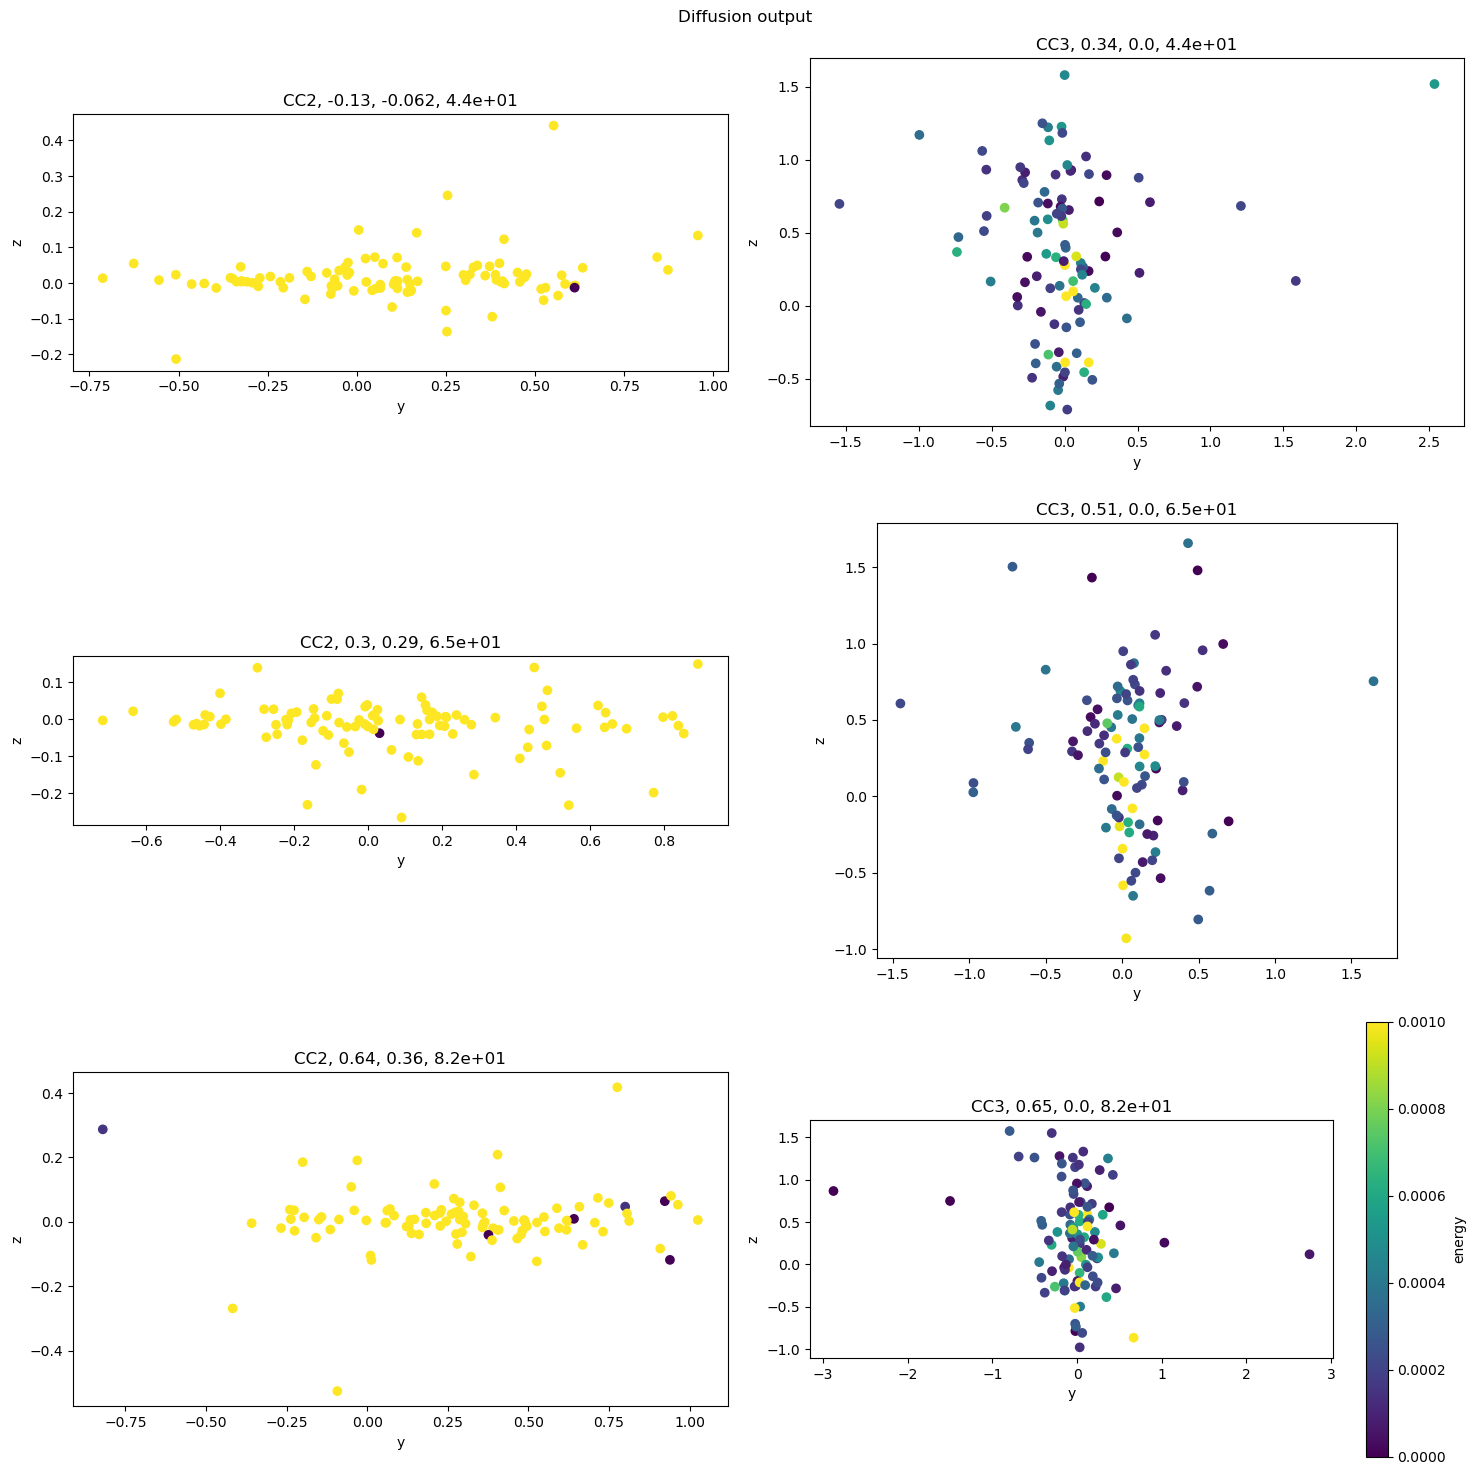

In [10]:
from matplotlib import pyplot as plt
min_energy = min(conditioned_samples["CC2"][0][..., -1].min(),
                 conditioned_samples["CC3"][0][..., -1].min())
max_energy = max(conditioned_samples["CC2"][0][..., -1].max(),
                 conditioned_samples["CC3"][0][..., -1].max())
min_energy = 0
max_energy = 0.001
use_events = [0, 51, 99]
fig, ax_arr = plt.subplots(len(use_events), 2, figsize=(15, len(use_events)*5))
fig.suptitle("Diffusion output")
for e, event in enumerate(use_events):
    for i, name in enumerate(conditioned_samples):
        s_diffusion, s_showerflow = conditioned_samples[name]
        s_diffusion = s_diffusion.detach()
        ax_arr[e, i].set_aspect(1)
        if "3" in name:
            energy_here = ((s_diffusion[event, :, 3]*Estd*2) + Emean).exp()
        else:
            energy_here = s_diffusion[event, :, 3]
        points = ax_arr[e, i].scatter(s_diffusion[event, :, 1], s_diffusion[event, :, 2], c=energy_here, vmin=min_energy, vmax=max_energy)
        ax_arr[e, i].set_title(f"{name}, {diffusion_cond[name][event, 0]:.2}, {diffusion_cond[name][event, 1]:.2}, {cond[event, 0]:.2}")
        ax_arr[e, i].set_xlabel("y")
        ax_arr[e, i].set_ylabel("z")
cbar = plt.colorbar(points)
cbar.set_label("energy")
plt.tight_layout()

In [11]:
from pointcloud.utils.showerflow_utils import truescale_showerflow_output
model_name = "CC2"
diffusion_m, sf_m, configs_m = cc_models[model_name]

import ipdb
if True:
    all_cond_meta = Metadata(all_cond_configs)
    if "3" in model_name:
        configs_m.metadata = cc_3_meta
    else:
        configs_m.metadata = cc_2_meta
    #ipdb.set_trace()
    np_ts, energy_ts, cog_x_ts, cog_y_ts, cog_z_ts, clusters_per_layer_ts, e_per_layer_ts = truescale_showerflow_output(conditioned_samples[model_name][1].clone(), configs_m)
    if np_ts is None:
        np_ts = clusters_per_layer_ts.sum(dim=1)
    if energy_ts is None:
        energy_ts = e_per_layer_ts.sum(dim=1)
    if "2" in model_name:
        cog_x_ts, cog_y_ts, cog_z_ts = cog_z_ts, cog_x_ts, cog_y_ts
print(np_ts.mean(), cog_x_ts.mean(), cog_y_ts.mean(), clusters_per_layer_ts.mean(), e_per_layer_ts.mean())

tensor(3311.5425, dtype=torch.float64) tensor(-0.0871) tensor(-0.5876) tensor(0.4035) tensor(0.3682)


In [12]:
from pointcloud.utils.gen_utils import gen_cond_showers_batch
# CC2
max_cond = 10_000
cond_m = {"showerflow":cond[:max_cond, [0]], "diffusion": cond[:max_cond, [0, 1]]}
diffusion_m, sf_m, configs_m = cc_models["CC2"]
all_cond_configs.device='cpu'
all_cond_configs.distillation = True
import ipdb
if True:
    import ipdb
    #ipdb.set_trace()
    cc2_events = gen_cond_showers_batch(diffusion_m, sf_m, cond_m, config=configs_m)

In [14]:
total_points_2s = (cc2_events[:, :, 3] > 0).sum(axis=1)
total_energy_2s = cc2_events[:, :, 3].sum(axis=1)/1000
#cog_x_2s = ((cc2_events[..., -1]*cc2_events[..., 0]/cc2_events[..., [-1]].sum(axis=1)).sum(axis=1)-all_cond_meta.mean_cog[0])/all_cond_meta.std_cog[0]
#cog_y_2s = ((cc2_events[..., -1]*cc2_events[..., 1]/cc2_events[..., [-1]].sum(axis=1)).sum(axis=1)-all_cond_meta.mean_cog[1])/all_cond_meta.std_cog[1]
cog_x_2s = (cc2_events[..., -1]*cc2_events[..., 0]/cc2_events[..., [-1]].sum(axis=1)).sum(axis=1)
cog_y_2s = (cc2_events[..., -1]*cc2_events[..., 1]/cc2_events[..., [-1]].sum(axis=1)).sum(axis=1)

In [15]:
from pointcloud.utils.gen_utils import gen_cond_showers_batch
# CC3
max_cond = 10_000
cond_m = {"showerflow":cond[:max_cond, [0, 2, 3, 4]], "diffusion": cond[:max_cond, [0, 2, 3, 4]]}
diffusion_m, sf_m, configs_m = cc_models["CC3"]
configs_m.device='cpu'
configs_m.metadata = cc_3_meta
#cc_3_meta.std_cog = cc_3_meta.std_cog[[2,0,1]]
if True:
    #ipdb.set_trace()
    cc3_events = gen_cond_showers_batch(diffusion_m, sf_m, cond_m, config=configs_m)



In [16]:
dataset_stats = np.load("/data/dust/user/dayhallh/data/ILCsoftEvents/p22_th90_ph90_en10-100_joined/stats.npz")
for key in dataset_stats.keys():
    print(key, dataset_stats[key])

path /data/dust/user/dayhallh/data/ILCsoftEvents/p22_th90_ph90_en10-100_joined/p22_th90_ph90_en10-100_seed{}_all_steps.hdf5
mean_point [ 1.22085438e-04  5.46113000e-01 -1.43398707e-02  3.42128658e-04]
std_point [5.01166184e-03 1.03514488e+00 2.80895001e-02 6.88304610e-04]
mean_event [ 3.82163269e-01  1.70949404e+03 -4.48880056e+01  1.07096315e+00]
std_event [5.18406994e-01 8.18390107e+02 2.19667064e+01 8.19594157e-01]
mean_n_points 3130.29362
std_n_points 1231.3112889384615
mean_cog [ 3.8028497e-01  1.8952594e+03 -4.9972588e+01]
std_cog [ 0.5199222  12.771177    0.48483732]


In [17]:
total_points_3s = (cc3_events[:, :, 3] > 0).sum(axis=1)
total_energy_3s = cc3_events[:, :, 3].sum(axis=1)/1000
cog_x_3s_raw = (cc3_events[..., -1]*cc3_events[..., 0]/cc3_events[..., [-1]].sum(axis=1)).sum(axis=1)
cog_x_3s = (cog_x_3s_raw-dataset_stats["mean_event"][0])/dataset_stats["std_event"][0]
cog_y_3s_raw = (cc3_events[..., -1]*cc3_events[..., 1]/events[..., [-1]].sum(axis=1)).sum(axis=1)
cog_y_3s = (cog_y_3s_raw-dataset_stats["mean_event"][1])/dataset_stats["std_event"][1]
print(cog_x_3s_raw.mean(), cog_x_3s_raw.std(), cog_y_3s_raw.mean(), cog_y_3s_raw.std())
print(cog_x_3s.mean(), cog_x_3s.std(), cog_y_3s.mean(), cog_y_3s.std())

0.08391971217457873 3.7715231762321775 46.47435650472965 1926.4016487790752
-0.5753077419161059 7.275216621225734 -2.0320623014670782 2.353891662749592


In [18]:
total_points_3s = (cc3_events[:, :, 3] > 0).sum(axis=1)
total_energy_3s = cc3_events[:, :, 3].sum(axis=1)/1000
cog_x_3s = (cc3_events[..., -1]*cc3_events[..., 0]/cc3_events[..., [-1]].sum(axis=1)).sum(axis=1)
#cog_x_3s = ((cc3_events[..., -1]*cc3_events[..., 0]/cc3_events[..., [-1]].sum(axis=1)).sum(axis=1)-dataset_stats["mean_event"][0])/dataset_stats["std_event"][0]
cog_y_3s = (cc3_events[..., -1]*cc3_events[..., 1]/cc3_events[..., [-1]].sum(axis=1)).sum(axis=1)
cog_z_3s = (cc3_events[..., -1]*cc3_events[..., 2]/cc3_events[..., [-1]].sum(axis=1)).sum(axis=1)

#cog_y_3s = ((cc3_events[..., -1]*cc3_events[..., 1]/cc3_events[..., [-1]].sum(axis=1)).sum(axis=1)-dataset_stats["mean_event"][1])/dataset_stats["std_event"][1]
print(cog_x_3s.mean(), cog_x_3s.std(), cog_y_3s.mean(), cog_y_3s.std(), cog_z_3s.mean(), cog_z_3s.std())

0.08391971217457873 3.7715231762321775 0.08565543349699292 2.8192262927930503 1894.8648352288674 12.982054415124953


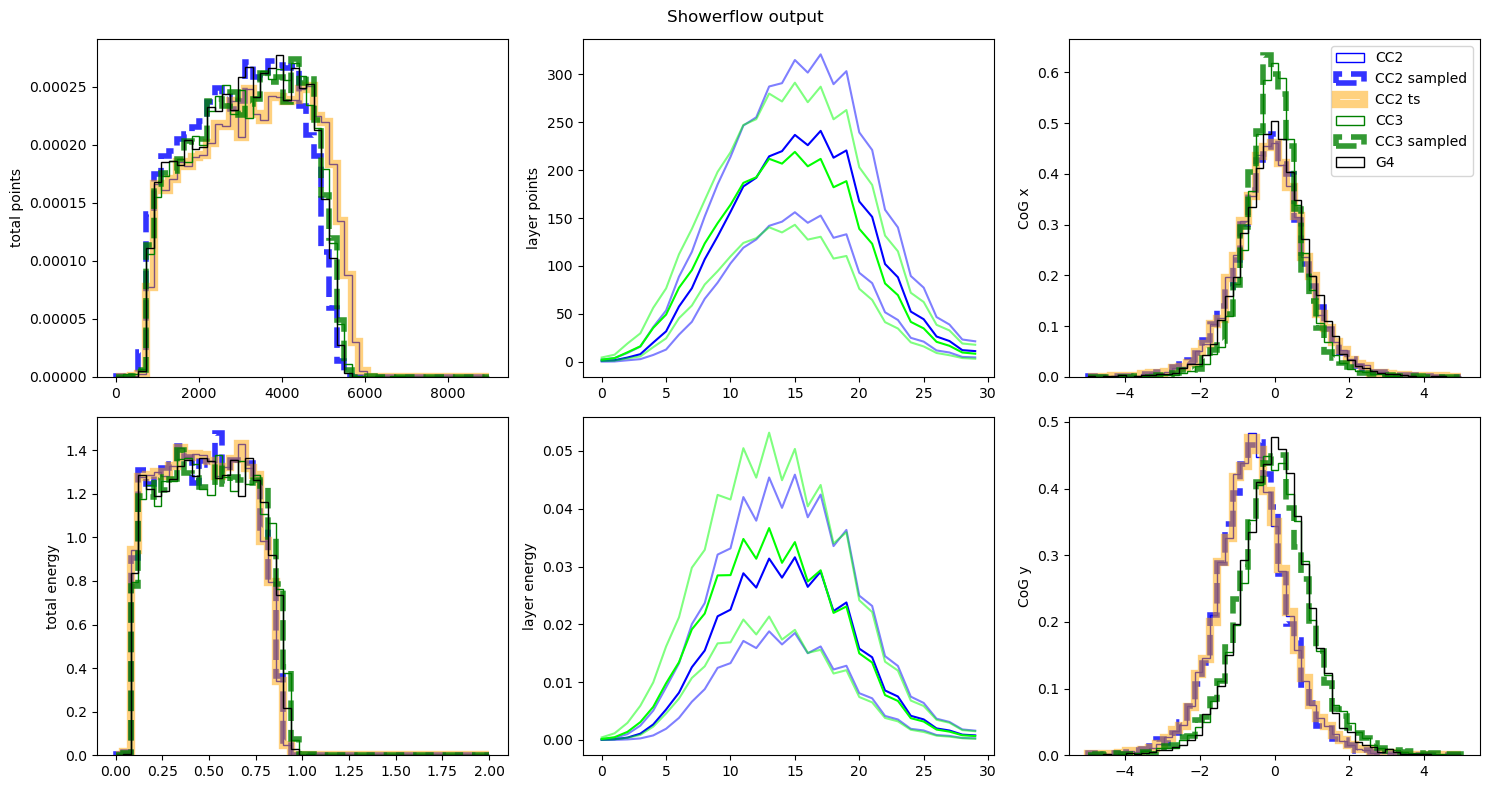

In [19]:
from matplotlib import pyplot as plt
fig, ax_arr = plt.subplots(2, 3, figsize=(15, 8))
ax_arr = ax_arr.flatten()
fig.suptitle("Showerflow output")
hist_common = dict(histtype='step', bins=np.linspace(-5, 5, 50), density=True)
hist2_settings = dict(label='CC2', color='blue')
hist2s_settings = dict(label='CC2 sampled', color='blue', linewidth=4, alpha=0.8, linestyle='--')
hist2ts_settings = dict(label=f'{model_name} ts', color='orange', linewidth=6, alpha=0.5)
hist3_settings = dict(label='CC3', color='green')
hist3s_settings = dict(label='CC3 sampled', color='green', linewidth=4, alpha=0.8, linestyle='--')
histg4_settings = dict(label='G4', color='k')
settings = [hist2_settings, hist2s_settings, hist2ts_settings, hist3_settings, hist3s_settings, histg4_settings]
for seti in settings:
    seti.update(hist_common)

i=2
ax_arr[i].set_ylabel("CoG x")
cc2_v = conditioned_samples["CC2"][1][:, 4]*cc_2_meta.std_cog[2]
cc3_v = conditioned_samples["CC3"][1][:, 0]*cc_3_meta.std_cog[0]

ax_arr[i].hist(cc2_v, **hist2_settings)
ax_arr[i].hist(cog_x_2s, **hist2s_settings)
ax_arr[i].hist(cog_x_ts, **hist2ts_settings)
ax_arr[i].hist(cc3_v, **hist3_settings)
ax_arr[i].hist(cog_x_3s, **hist3s_settings)
ax_arr[i].hist(cog_x, **histg4_settings)
ax_arr[i].legend()

i=5
ax_arr[i].set_ylabel("CoG y")
cc2_v = conditioned_samples["CC2"][1][:, 2]*cc_2_meta.std_cog[0]
cc3_v = conditioned_samples["CC3"][1][:, 1]*cc_3_meta.std_cog[1]

ax_arr[i].hist(cc2_v, **hist2_settings)
ax_arr[i].hist(cog_y_2s, **hist2s_settings)
ax_arr[i].hist(cog_y_ts, **hist2ts_settings)
ax_arr[i].hist(cc3_v, **hist3_settings)
ax_arr[i].hist(cog_y_3s, **hist3s_settings)
ax_arr[i].hist(cog_y, **histg4_settings)

i=0
# total points
for seti in settings:
    seti['bins'] = np.linspace(0, 9000, 50)
    
ax_arr[i].set_ylabel("total points")
cc2_v = (float(all_cond_meta.n_pts_rescale)*conditioned_samples["CC2"][1][:, 0]).clip(1, 60_000)
cc3_v = float(cc_3_meta.n_pts_rescale)*conditioned_samples["CC3"][1][:, -60:-30].sum(dim=1)/30

ax_arr[i].hist(cc2_v, **hist2_settings)
ax_arr[i].hist(total_points_2s, **hist2s_settings)
ax_arr[i].hist(np_ts, **hist2ts_settings)
ax_arr[i].hist(cc3_v, **hist3_settings)
ax_arr[i].hist(total_points_3s, **hist3s_settings)
ax_arr[i].hist(n_pnts, **histg4_settings)

i=1
ax_arr[i].set_ylabel("layer points") 
layer_pnts2 = np.zeros((3, 30))
raw = conditioned_samples["CC2"][1][:, -60:-30].clip(0, 1)
raw_totals = raw.sum(dim=1)
renormed = raw*(cc2_v[:, None]/raw_totals[:, None])
layer_pnts3 = np.zeros((3, 30))
quantiles = [0.25, 0.5, 0.75]
for l in range(30):
    layer_pnts2[:, l] = np.quantile(renormed[:, l], quantiles)
    layer_pnts3[:, l] = float(cc_3_meta.n_pts_rescale)*np.quantile(conditioned_samples["CC3"][1][:, -60+l], quantiles)/30
colour = ((0, 0, 1, 0.5), (0, 0, 1, 1), (0, 0, 1, 0.5))
for j in range(3):
    ax_arr[i].plot(range(30), layer_pnts2[j], color=colour[j])
colour = ((0, 1, 0, 0.5), (0, 1, 0, 1), (0, 1, 0, 0.5))
for j in range(3):
    ax_arr[i].plot(range(30), layer_pnts3[j], color=colour[j])



i=3
# total energy
for seti in settings:
    seti['bins'] = np.linspace(0, 2, 50)
    
ax_arr[i].set_ylabel("total energy")
cc2_v = conditioned_samples["CC2"][1][:, 1]
cc3_v = cc_3_meta.vis_eng_rescale*conditioned_samples["CC3"][1][:, -30:].sum(dim=1)/30

ax_arr[i].hist(cc2_v, **hist2_settings)
ax_arr[i].hist(total_energy_2s, **hist2s_settings)
ax_arr[i].hist(energy_ts/1000, **hist2ts_settings)
ax_arr[i].hist(cc3_v, **hist3_settings)
ax_arr[i].hist(total_energy_3s, **hist3s_settings)
ax_arr[i].hist(energy, **histg4_settings)

i=4
ax_arr[i].set_ylabel("layer energy")
layer_e2 = np.zeros((3, 30))
raw = conditioned_samples["CC2"][1][:, -30:].clip(0, 1)
renormed = raw*(cc2_v[:, None]/raw_totals[:, None])
layer_e3 = np.zeros((3, 30))
quantiles = [0.25, 0.5, 0.75]
for l in range(30):
    layer_e2[:, l] = np.quantile(renormed[:, l], quantiles)
    layer_e3[:, l] = np.quantile(cc_3_meta.vis_eng_rescale*conditioned_samples["CC3"][1][:, -30+l], quantiles)/30
colour = ((0, 0, 1, 0.5), (0, 0, 1, 1), (0, 0, 1, 0.5))
for j in range(3):
    ax_arr[i].plot(range(30), layer_e2[j], color=colour[j])
colour = ((0, 1, 0, 0.5), (0, 1, 0, 1), (0, 1, 0, 0.5))
for j in range(3):
    ax_arr[i].plot(range(30), layer_e3[j], color=colour[j])

plt.tight_layout()

In [20]:
for line_3, line_2 in zip(repr(cc_3_meta).split('\n'), repr(cc_2_meta).split('\n')):
    print(line_3 + '\t' + line_2)
    

Metadata for /data/dust/user/dayhallh/data/ILCsoftEvents/p22_th90_ph90_en10-100_joined/p22_th90_ph90_en10-100_seed{}_all_steps.hdf5	Metadata for /data/dust/user/dayhallh/data/ILCsoftEvents/p22_th90_ph90_en10-100_joined/p22_th90_ph90_en10-100_seed{}_all_steps.hdf5
layer_bottom_pos_hdf5: [1811.34020996 1814.46508789 1823.81005859 1826.93505859 1836.2800293	layer_bottom_pos_hdf5: [1811.34020996 1814.46508789 1823.81005859 1826.93505859 1836.2800293
 1839.4050293  1848.75       1851.875      1861.2199707  1864.3449707	 1839.4050293  1848.75       1851.875      1861.2199707  1864.3449707
 1873.68994141 1876.81494141 1886.16003418 1889.28503418 1898.63000488	 1873.68994141 1876.81494141 1886.16003418 1889.28503418 1898.63000488
 1901.75500488 1911.09997559 1914.22497559 1923.56994629 1926.69494629	 1901.75500488 1911.09997559 1914.22497559 1923.56994629 1926.69494629
 1938.14001465 1943.36499023 1954.81005859 1960.03503418 1971.47998047	 1938.14001465 1943.36499023 1954.81005859 1960.0350341

In [21]:
conditioned_raws = {"CC2": {"total_pnts": conditioned_samples["CC2"][1][:, 0],
                            "total_energy": conditioned_samples["CC2"][1][:, 1],
                            "cog_x": conditioned_samples["CC2"][1][:, 2],
                            "cog_y": conditioned_samples["CC2"][1][:, 3],
                            "cog_z": conditioned_samples["CC2"][1][:, 4]},
                    "CC3": {"total_pnts": conditioned_samples["CC3"][1][:, -60:-30].sum(dim=1),
                            "total_energy": conditioned_samples["CC3"][1][:, -30:].sum(dim=1),
                            "cog_x": conditioned_samples["CC3"][1][:, 0],
                            "cog_y": conditioned_samples["CC3"][1][:, 1]}}
                            
                            

In [23]:
print("STD CC2")
cc2_conditioned_stds = {key + "_std":conditioned_raws["CC2"][key].std() for key in conditioned_raws["CC2"]}
print(cc2_conditioned_stds)
print("STD CC3")
cc3_conditioned_stds = {key + "_std":conditioned_raws["CC3"][key].std() for key in conditioned_raws["CC3"]}
print(cc3_conditioned_stds)
print("Mean CC2")
cc2_conditioned_means = {key + "_mean":conditioned_raws["CC2"][key].mean() for key in conditioned_raws["CC2"]}
print(cc2_conditioned_means)
print("Mean CC3")
cc3_conditioned_means = {key + "_mean":conditioned_raws["CC3"][key].mean() for key in conditioned_raws["CC3"]}
print(cc3_conditioned_means)
#np.savez(cc2_showerflow_path.replace(".pth", "_stats_cond_p22_th90_ph90_en10-100.npz"), **cc2_conditioned_stds, **cc2_conditioned_means)
#np.savez(cc3_showerflow_path.replace(".pth", "_stats_cond_p22_th90_ph90_en10-100.npz"), **cc3_conditioned_stds, **cc3_conditioned_means)

STD CC2
{'total_pnts_std': tensor(0.2634), 'total_energy_std': tensor(0.2169), 'cog_x_std': tensor(0.0186), 'cog_y_std': tensor(0.1243), 'cog_z_std': tensor(0.0217)}
STD CC3
{'total_pnts_std': tensor(4.7490), 'total_energy_std': tensor(5.0552), 'cog_x_std': tensor(1.2089), 'cog_y_std': tensor(1.0092)}
Mean CC2
{'total_pnts_mean': tensor(0.6623), 'total_energy_mean': tensor(0.4702), 'cog_x_mean': tensor(-0.0113), 'cog_y_mean': tensor(-0.0122), 'cog_z_mean': tensor(-0.0019)}
Mean CC3
{'total_pnts_mean': tensor(12.0455), 'total_energy_mean': tensor(10.9279), 'cog_x_mean': tensor(0.0399), 'cog_y_mean': tensor(0.0447)}
